<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/Model_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load in relevant libraries, and alias where appropriate
import numpy as np # linear algebra
import tensorflow as tf #library สำหรับสร้าง machine learning models แบบ open source จาก Google
import math # เรียกใช้ module เพื่อคำนวณค่าต่างๆ 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
!pip install optim
import torch.optim as optim
!pip install torch torchvision torchaudio
from torchvision.io import read_image
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for optim: filename=optim-0.1.0-py2.py3-none-any.whl size=2718 sha256=24c4fb9a20ceca13e39b8876a5a69f5242d3c6e6268dfccc68bf0c9488c335fc
  Stored in directory: /root/.cache/pip/wheels/ff/4a/36/b79913118fc97698a8b4eef8afd534a8b1fc4f1f36903bf67d
Successfully built optim
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) # เป็น library ในการจัดการ dataframe

In [3]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์

In [6]:
path = '/content/drive/My Drive/Project_Boneage'  # ชี้ว่า data เราอยู่โฟล์เดอร์ไหน

In [7]:
#loading dataframes # เอาที่อยู่ของไฟล์เชื่อมกับที่อยู่ของไฟล์เรา โดยกำหนดชื่่อไฟล์ที่เราต้องการ
train_path = os.path.join(path,'train.csv')
train_dataset = pd.read_csv(train_path)
validation_path = os.path.join(path,'validation.csv')
validation_dataset = pd.read_csv(validation_path)
test_path = os.path.join(path,'boneage-test-dataset.csv')
test_dataset = pd.read_csv(test_path)

In [8]:
train_dataset

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
...,...,...,...
10084,13259,94,False
10085,13261,94,False
10086,13274,94,False
10087,13286,94,False


In [9]:
validation_dataset

,id,boneage,male
0,10186,10,True
1,10758,15,False
2,10860,180,False
3,10877,180,False
4,11008,180,False
...,...,...,...
2517,15605,50,False
2518,15606,113,False
2519,15608,55,False
2520,15609,150,True


In [10]:
test_dataset

,Case ID,Sex,Ground truth bone age (months)
0,4360,M,169
1,4361,M,170
2,4362,M,73
3,4363,M,153
4,4364,M,135
...,...,...,...
195,4555,F,133
196,4556,F,129
197,4557,F,168
198,4558,F,136


In [11]:
#appending file extension to id column for both training and testing dataframes
# ต่อท้าย data ใน column 'id' ด้วย .png
train_dataset['id'] = train_dataset['id'].apply(lambda x: str(x)+'.png') # ทำการเปลี่ยน type ใน column 'id' จาก int  เป็น string เพื่อให้สามารถต่อท้ายด้วย .png ได้ # ฟังก์ชันแลมบ์ดาเป็นฟังก์ชันที่ไม่ระบุตัวตนขนาดเล็ก
validation_dataset['id'] = validation_dataset['id'].apply(lambda x: str(x)+'.png') 
test_dataset['Case ID'] = test_dataset['Case ID'].apply(lambda x: str(x)+'.png') 

train_dataset.head() # แสดงค่าของ train_df บางส่วน

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


In [12]:
train_dataset['gender'] = train_dataset['male'].apply(lambda x: 'male' if x else 'female') # ทำการเปลี่ยนค่าข้อมูล gender จาก true -> male, false -> female 
train_dataset['gender']

0        female
1        female
2        female
3          male
4        female
          ...  
10084    female
10085    female
10086    female
10087    female
10088    female
Name: gender, Length: 10089, dtype: object

In [13]:
validation_dataset['gender'] = validation_dataset['male'].apply(lambda x: 'male' if x else 'female') # ทำการเปลี่ยนค่าข้อมูล gender จาก true -> male, false -> female 
validation_dataset['gender']

0         male
1       female
2       female
3       female
4       female
         ...  
2517    female
2518    female
2519    female
2520      male
2521      male
Name: gender, Length: 2522, dtype: object

In [14]:
import matplotlib.image as mpimg #นำเข้า library ที่ใช้อ่านรูป
import matplotlib.pyplot as plt # เป็น module พื้นฐานที่ใช้ในการสร้างกราฟของ python

In [15]:
train_img_path= os.path.join(path,'boneage_training_dataset/')
validation_img_path = os.path.join(path,'boneage_validation_dataset/')
test_img_path = os.path.join(path,'boneage-test-dataset/')

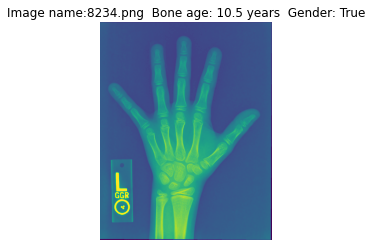

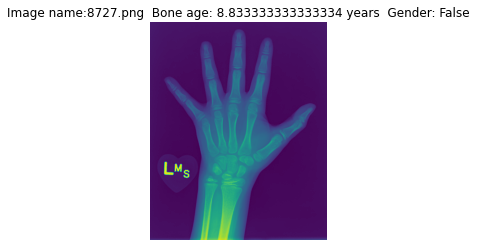

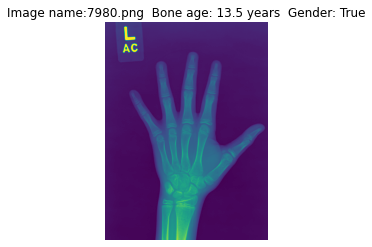

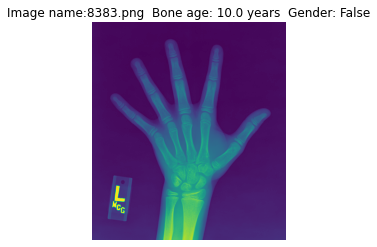

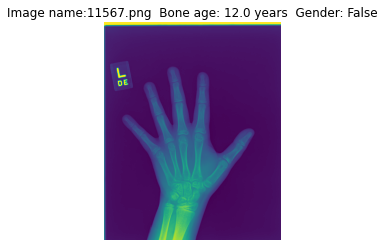

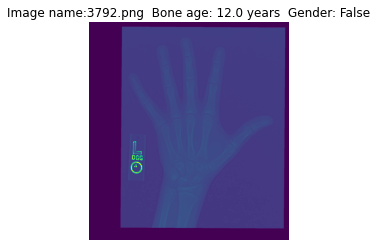

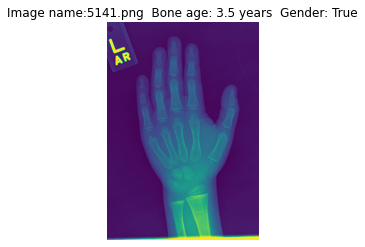

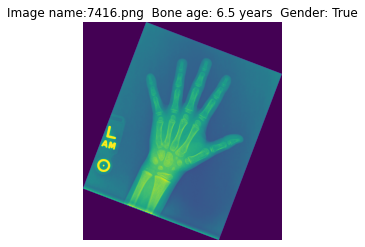

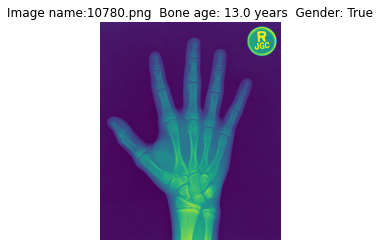

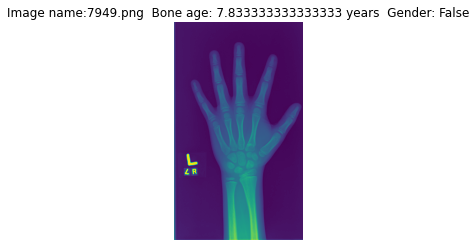

In [16]:
for filename, boneage, gender in train_dataset[['id','boneage','male']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ อายุ เพศ)
    train_img = mpimg.imread(os.path.join(path,'boneage_training_dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.imshow(train_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

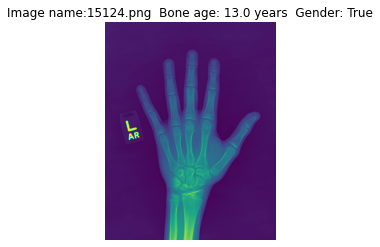

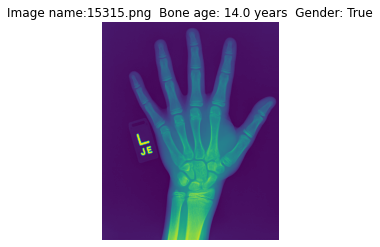

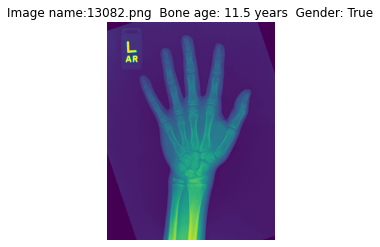

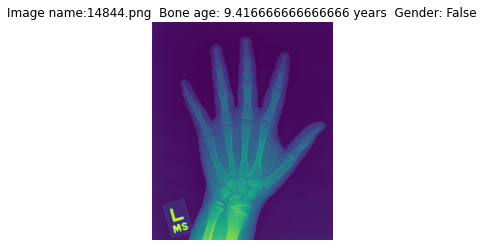

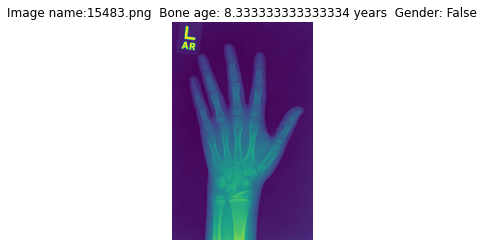

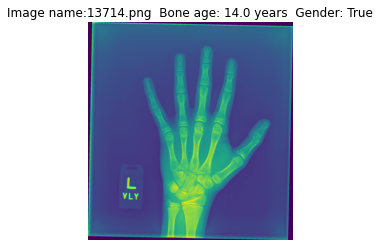

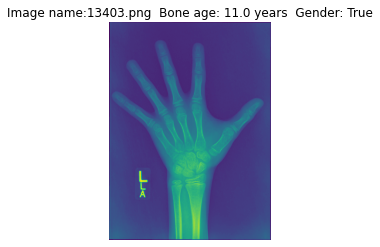

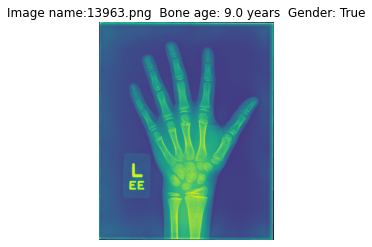

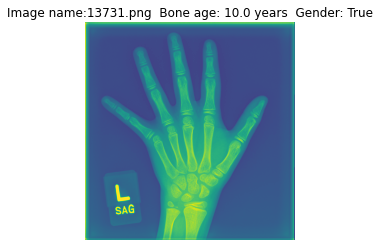

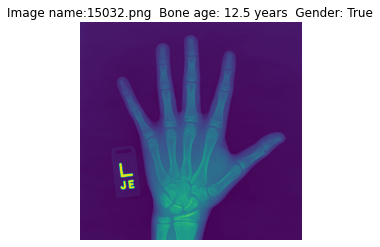

In [17]:
for filename, boneage, gender in validation_dataset[['id','boneage','male']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ อายุ เพศ)
    validation_img = mpimg.imread(os.path.join(path,'boneage_validation_dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.imshow(validation_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

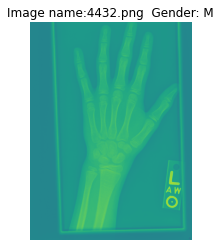

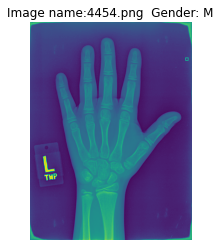

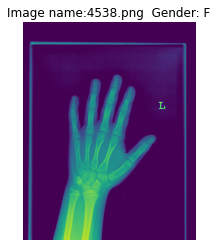

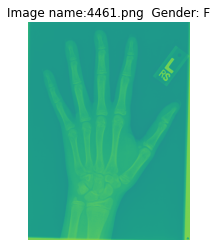

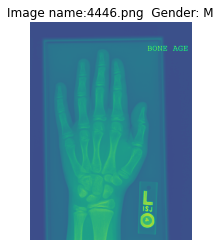

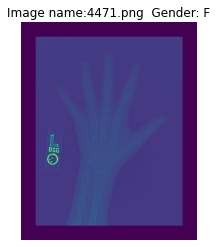

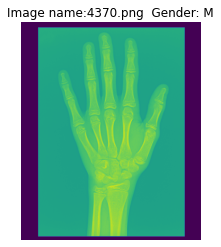

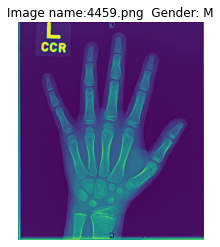

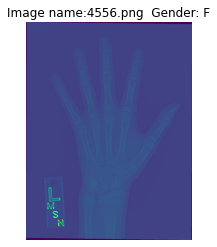

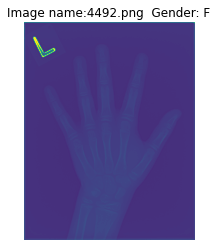

In [18]:
for filename, gender in test_dataset[['Case ID','Sex']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ เพศ)
    test_img = mpimg.imread(os.path.join(path,'boneage-test-dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.title('Image name:{}  Gender: {}'.format(filename, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.imshow(test_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

In [19]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
!pip install Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.8 MB/s eta 0:00:00


In [20]:
train_dir = '/content/drive/My Drive/Project_Boneage/boneage_training_dataset'

In [21]:
train_transform = transforms.Compose([transforms.Resize((500, 500)),
                               transforms.RandomAffine(
                                   20, translate=(0.2, 0.2),
                                   scale=(1, 1.2)),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor()])
train_transform

Compose(
    Resize(size=(500, 500), interpolation=bilinear, max_size=None, antialias=None)
    RandomAffine(degrees=[-20.0, 20.0], translate=(0.2, 0.2), scale=(1, 1.2))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

In [22]:
validation_transform = transforms.Compose([transforms.Resize((500, 500)),
                               transforms.ToTensor()])
validation_transform

Compose(
    Resize(size=(500, 500), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [23]:
test_transform = transforms.Compose([transforms.Resize((500, 500)),
                               transforms.ToTensor()])
test_transform

Compose(
    Resize(size=(500, 500), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [24]:
import os
os.getcwd()
# place the files in your IDE working dicrectory .
train = pd.read_csv(r'/content/drive/My Drive/Project_Boneage/train.csv')
validation = pd.read_csv(r'/content/drive/My Drive/Project_Boneage/validation.csv')
test = pd.read_csv(r'/content/drive/My Drive/Project_Boneage/boneage-test-dataset.csv')
train_path = r'/content/drive/My Drive/Project_Boneage/boneage_training_dataset'
validation_path = r'/content/drive/My Drive/Project_Boneage/boneage_validation_dataset'
test_path = r'/content/drive/My Drive/Project_Boneage/boneage-test-dataset'

In [25]:
train.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


In [26]:
import matplotlib.image as img

In [33]:
from netCDF4 import Dataset

In [34]:
class BoneDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [35]:
train_data = BoneDataset(train, train_path, train_transform )
valid_data = BoneDataset(validation, train_path, validation_transform )
test_data = BoneDataset(test, test_path, test_transform )

TypeError: ignored

# Model

# Training